# Bellingham Stormwater Monitoring Analysis

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from IPython.display import display, HTML

# Define the CSS to set the height of the output container
css_style = """
<style>
    div.output_area {
        height: 800px; /* Adjust this value based on your needs */
        overflow-y: auto; /* Vertical scroll */
        overflow-x: auto; /* Horizontal scroll */
    }
</style>
"""
# Apply the CSS style to the notebook
display(HTML(css_style))

pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_columns', 1000) 

## TODO
1. Review the other site data as well as Bellingham
2. Determine treatment of duplicates
3. Add F chart to show variability.  Review F-Chart calcs from stats book.  Not std
4. Research how e.coli data is collected
5. What is variability with time and incubation?
6. Verify that all these tests were taken with similar methods (R-Card, lab, ...).  Comments refer to counts on some measurements which allude to R-Card
7. Convert to plots using Tidy dataset frame and not stack (plotly)


![Bacteria](e.coli-sampling-protocol.png) 

In [9]:
data = pd.read_csv('Salish Sea Stormwater Monitoring Database-20240528.csv')

print(data.columns)

## Clean

In [10]:
# Remove 'Unnamed' columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')].dropna(how='all')
data

,City Code,Site ID,Sample Date,Sample \nTime 24 hr\nhh:mm,Prior 24 hr\nRainfall inches,Prior 72 hr\nRainfall inches,Est. Tide Height feet,Flow Rate,Outflow > expected No=1 Yes=2,Air Temp °C,Water Temp °C,Dissolved Oxygen\nmg/l,pH,Conductivity\n(SPC)\nuS/cm,Salinity ppt,Turbidity\nNTU,E. Coli,Duplicate E. coli \ncfu/100ml,Enterococcus,Duplicate Enterococcus cfu/100ml,Color,Odor,Visual,Comments
0,BEL,Bennett Ave,02-03-21,NaN,NaN,2.30,NaN,Present,1.0,8.9,10.1,11.09,7.44,212.10,0.10,9.00,340.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN
1,BEL,Bennett Ave,03-16-21,NaN,NaN,0.14,NaN,Present,1.0,9.4,10.1,10.19,7.81,293.20,0.14,9.00,7040.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN
2,BEL,Bennett Ave,04-15-21,NaN,NaN,0.00,NaN,Present,1.0,20.0,11.8,NaN,7.46,303.30,0.15,9.00,760.0,NaN,NaN,NaN,0.0,0.0,0.0,DO probe not working
3,BEL,Bennett Ave,05-11-21,NaN,NaN,0.01,NaN,Present,1.0,17.3,13.6,NaN,7.60,240.00,0.15,9.00,460.0,NaN,NaN,NaN,0.0,0.0,0.0,DO probe not working
4,BEL,Bennett Ave,06-08-21,NaN,NaN,0.13,NaN,Present,1.0,22.1,14.4,10.20,7.60,282.60,0.14,9.00,280.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN
5,BEL,Bennett Ave,07-06-21,NaN,NaN,0.00,NaN,Present,1.0,22.2,16.6,9.33,7.46,236.40,0.13,9.00,1540.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN
6,BEL,Bennett Ave,08-11-21,NaN,NaN,0.16,NaN,Present,1.0,22.3,17.9,9.30,7.38,322.30,0.15,9.00,2560.0,NaN,NaN,NaN,0.0,0.0,0.0,Bacteria - in addition to high E. coli there w...
7,BEL,Bennett Ave,09-07-21,NaN,NaN,0.18,NaN,Present,1.0,22.8,16.8,10.45,7.83,353.40,0.17,9.00,180.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN
8,BEL,Bennett Ave,10-04-21,NaN,NaN,0.53,NaN,Present,1.0,14.2,15.2,9.88,7.81,303.20,0.15,9.00,540.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN
9,BEL,Bennett Ave,11-01-21,NaN,NaN,0.00,NaN,Present,1.0,7.2,13.1,10.00,7.79,273.50,0.13,9.00,420.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN


In [11]:
# Identify duplicates
duplicates = data[data.duplicated(keep=False)]
data['is_duplicate'] = data.duplicated(subset=['Site ID', 'Sample Date'], keep=False)

#display(data[data['is_duplicate'] == True])
data[data['is_duplicate'] == True]

,City Code,Site ID,Sample Date,Sample \nTime 24 hr\nhh:mm,Prior 24 hr\nRainfall inches,Prior 72 hr\nRainfall inches,Est. Tide Height feet,Flow Rate,Outflow > expected No=1 Yes=2,Air Temp °C,Water Temp °C,Dissolved Oxygen\nmg/l,pH,Conductivity\n(SPC)\nuS/cm,Salinity ppt,Turbidity\nNTU,E. Coli,Duplicate E. coli \ncfu/100ml,Enterococcus,Duplicate Enterococcus cfu/100ml,Color,Odor,Visual,Comments,is_duplicate
11,BEL,Bennett Ave,01-13-22,NaN,NaN,0.64,NaN,Present,1.0,5.5,9.8,11.51,7.65,254.50,0.12,9.00,1000.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,True
12,BEL,Bennett Ave,01-13-22,NaN,NaN,0.64,NaN,Present,1.0,5.5,9.9,11.46,7.63,254.40,0.12,9.00,1280.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,True
13,BEL,Bennett Ave,02-24-22,NaN,NaN,0.10,NaN,Present,1.0,3.0,8.8,12.05,8.03,306.30,0.15,9.00,420.0,NaN,NaN,NaN,0.0,0.0,0.0,Some floaties in the water; Snowed last night,True
14,BEL,Bennett Ave,02-24-22,NaN,NaN,0.10,NaN,Present,1.0,3.0,8.9,11.75,7.98,308.60,0.15,9.00,360.0,NaN,NaN,NaN,0.0,0.0,0.0,Some floaties in the water; Snowed last night;...,True
35,BEL,Bennett Ave,11-22-23,17:50,0.21,NaN,NaN,Present,1.0,8.6,11.3,7.44,7.85,221.20,0.11,0.00,155.0,NaN,5.0,NaN,0.0,0.0,0.0,NaN,True
36,BEL,Bennett Ave,11-22-23,17:50,0.21,NaN,NaN,Present,1.0,8.6,11.8,7.31,7.83,222.20,0.11,0.00,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,True
39,BEL,Bennett Ave,02-07-24,19:12,0.02,NaN,-1.9,Moderate,1.0,8.1,9.7,11.80,7.57,317.14,0.15,3.13,175.0,NaN,60.0,NaN,0.0,0.0,1.0,visual: foam,True
40,BEL,Bennett Ave,02-07-24,19:18,0.02,NaN,-1.9,Moderate,1.0,9.2,9.7,11.50,7.75,320.00,0.15,1.13,185.0,NaN,60.0,NaN,0.0,0.0,1.0,visual: foam,True
42,BEL,Broadway St,02-03-21,NaN,NaN,2.30,NaN,Present,1.0,8.9,8.7,11.51,7.55,249.20,0.12,9.00,260.0,NaN,NaN,NaN,0.0,1.0,0.0,Odor - rotten eggs,True
43,BEL,Broadway St,02-03-21,NaN,NaN,2.30,NaN,Present,1.0,8.9,8.7,11.13,7.45,247.70,0.12,9.00,300.0,NaN,NaN,NaN,0.0,1.0,0.0,odor - rotten egg; duplicate sample,True


In [12]:
data.columns

Index(['City Code', 'Site ID', 'Sample Date', 'Sample \nTime 24 hr\nhh:mm',
       'Prior 24 hr\nRainfall  inches', 'Prior 72 hr\nRainfall  inches',
       'Est. Tide Height     feet', 'Flow Rate',
       'Outflow > expected   No=1 Yes=2', 'Air Temp  °C', 'Water Temp   °C',
       'Dissolved Oxygen\nmg/l', 'pH', 'Conductivity\n(SPC)\nuS/cm',
       'Salinity ppt', 'Turbidity\nNTU', 'E. Coli',
       'Duplicate E. coli \ncfu/100ml', 'Enterococcus',
       'Duplicate Enterococcus cfu/100ml', 'Color', 'Odor', 'Visual',
       'Comments', 'is_duplicate'],
      dtype='object')

In [13]:
# Process dates and relevant columns for E. coli and Enterococcus
data['Sample Date'] = pd.to_datetime(data['Sample Date'], errors='coerce', format='%m-%d-%y')

ecoli = data[['Sample Date', 'Site ID', 'E. Coli', 'Comments', 'is_duplicate']]

# Extract the month for aggregation in ecoli
ecoli['Month'] = ecoli['Sample Date'].dt.to_period('M')  # Convert date to month period for grouping

enterococcus = data[['Sample Date', 'Site ID', 'Enterococcus', 'Comments', 'is_duplicate']]
# Extract the month for aggregation in ecoli
enterococcus['Month'] = enterococcus['Sample Date'].dt.to_period('M')  # Convert date to month period for grouping

# Sort data by date
ecoli = ecoli.sort_values('Sample Date')
enterococcus = enterococcus.sort_values('Sample Date')

C:\Users\gwlund.LEINET\AppData\Local\Temp\ipykernel_44524\2701677476.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecoli['Month'] = ecoli['Sample Date'].dt.to_period('M')  # Convert date to month period for grouping
C:\Users\gwlund.LEINET\AppData\Local\Temp\ipykernel_44524\2701677476.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enterococcus['Month'] = enterococcus['Sample Date'].dt.to_period('M')  # Convert date to month period for grouping


In [14]:
ecoli.site_id = 'Bennett Ave'

In [15]:
enterococcus

,Sample Date,Site ID,Enterococcus,Comments,is_duplicate,Month
134,2020-12-03,Cedar St,NaN,NaN,False,2020-12
87,2020-12-03,C St,NaN,Odor of rotten eggs,False,2020-12
311,2021-02-03,Squalicum Creek,NaN,Color - brown: Visual - foam,False,2021-02
88,2021-02-03,C St,NaN,color - milky; odor - rotten eggs and mold; Fi...,False,2021-02
177,2021-02-03,Cornwall St,NaN,NaN,False,2021-02
359,2021-02-03,Whatcom Creek,NaN,NaN,False,2021-02
135,2021-02-03,Cedar St,NaN,NaN,False,2021-02
43,2021-02-03,Broadway St,NaN,odor - rotten egg; duplicate sample,True,2021-02
42,2021-02-03,Broadway St,NaN,Odor - rotten eggs,True,2021-02
243,2021-02-03,Olive St,NaN,NaN,False,2021-02


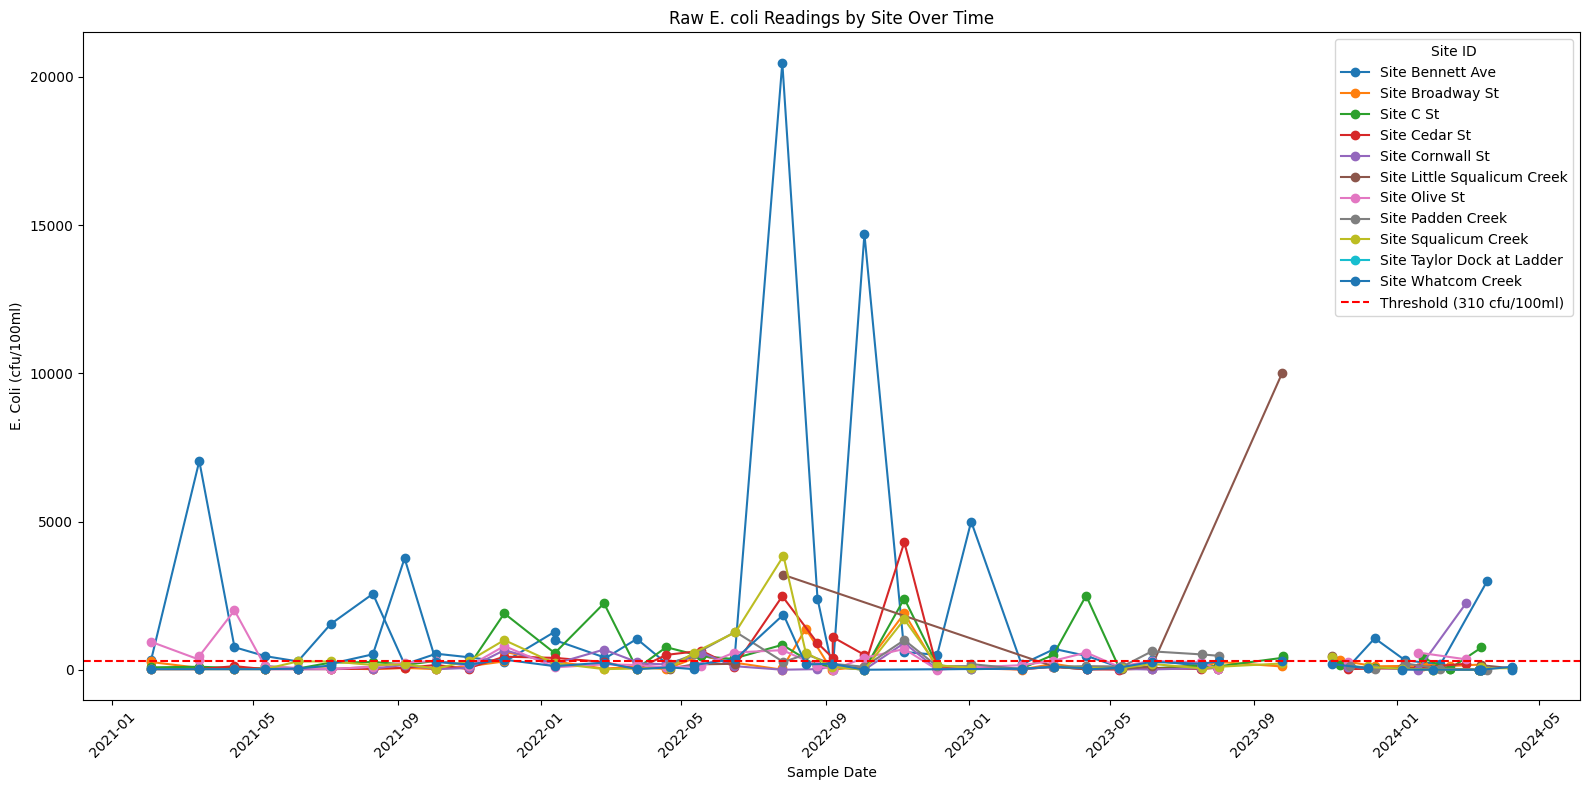

In [16]:
fig, ax = plt.subplots(figsize=(16, 8))
for site_id, group in ecoli.groupby('Site ID'):
    ax.plot(group['Sample Date'], group['E. Coli'], marker='o', linestyle='-', label=f'Site {site_id}')

ax.set_title('Raw E. coli Readings by Site Over Time')
ax.set_xlabel('Sample Date')
ax.set_ylabel('E. Coli (cfu/100ml)')
ax.axhline(y=310, color='red', linestyle='--', label='Threshold (310 cfu/100ml)')
ax.legend(title='Site ID')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

Bennett Ave Data has mnay outliers 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


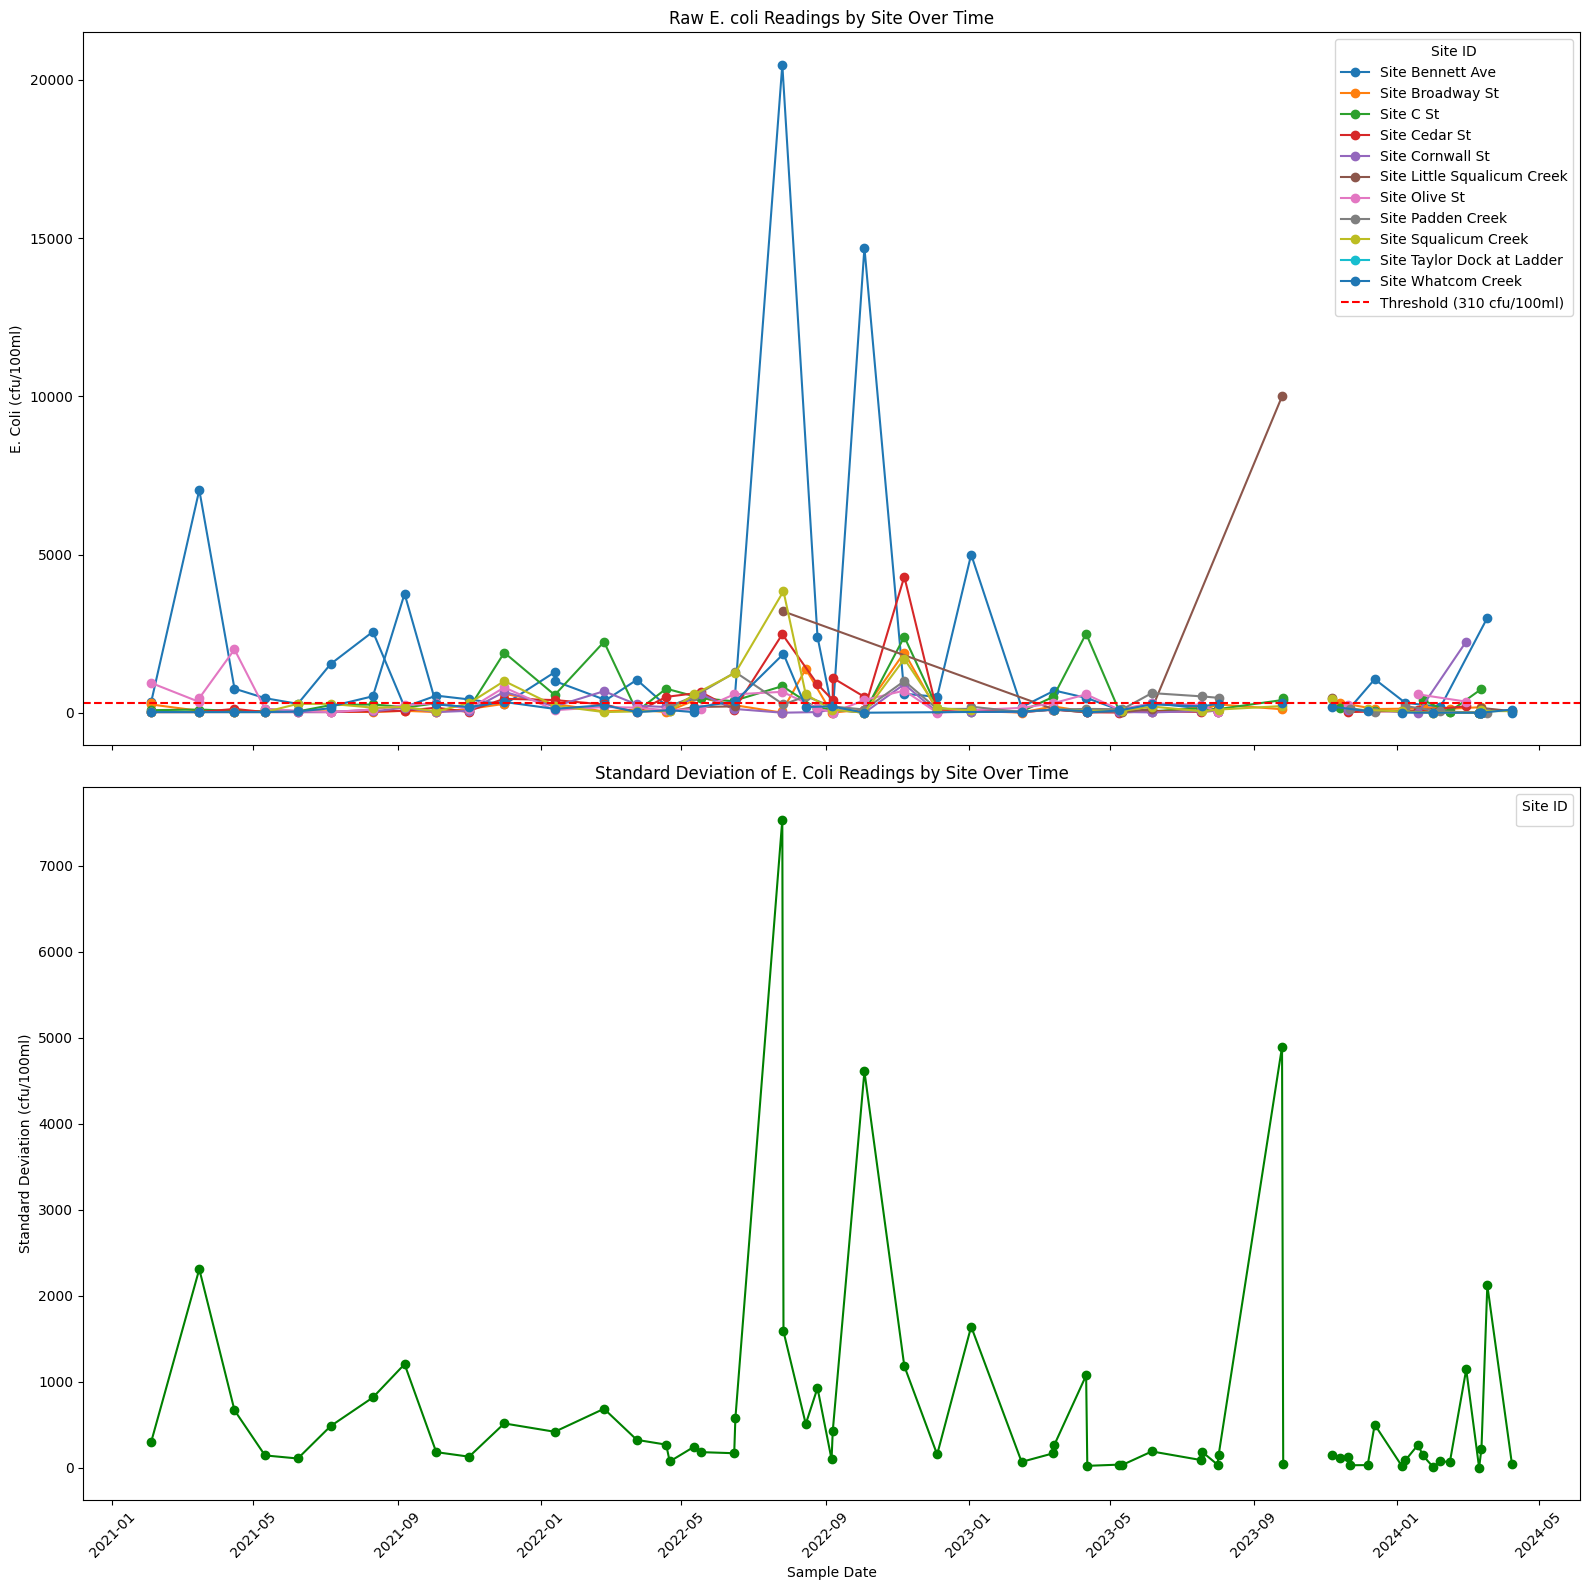

In [17]:
# Create a figure with two subplots (ax for raw readings and ax2 for variability F-chart)
fig, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), sharex=True)

# Plotting E. Coli readings by Site
for site_id, group in ecoli.groupby('Site ID'):
    ax.plot(group['Sample Date'], group['E. Coli'], marker='o', linestyle='-', label=f'Site {site_id}')

ax.set_title('Raw E. coli Readings by Site Over Time')
ax.set_ylabel('E. Coli (cfu/100ml)')
ax.axhline(y=310, color='red', linestyle='--', label='Threshold (310 cfu/100ml)')
ax.legend(title='Site ID')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Plotting F-chart of variability (Standard Deviation over time)
# Calculating standard deviation for each date
std_dev_by_date = ecoli.groupby('Sample Date')['E. Coli'].std()
ax2.plot(std_dev_by_date.index, std_dev_by_date, marker='o', linestyle='-', color='green')

# Plotting F-chart of variability (Standard Deviation over time) by Site ID

#for site_id, group in ecoli.groupby('Site ID'):
#    std_dev = group.groupby('Sample Date')['E. Coli'].std()
#    ax2.plot(std_dev.index, std_dev, marker='o', linestyle='-', label=f'Site {site_id}')

ax2.set_title('Standard Deviation of E. Coli Readings by Site Over Time')
ax2.set_xlabel('Sample Date')
ax2.set_ylabel('Standard Deviation (cfu/100ml)')
ax2.legend(title='Site ID')

plt.tight_layout()
plt.show()

In [18]:
ecoli[ecoli['Site ID'] == 'Bennett Ave']

,Sample Date,Site ID,E. Coli,Comments,is_duplicate,Month
0,2021-02-03,Bennett Ave,340.0,NaN,False,2021-02
1,2021-03-16,Bennett Ave,7040.0,NaN,False,2021-03
2,2021-04-15,Bennett Ave,760.0,DO probe not working,False,2021-04
3,2021-05-11,Bennett Ave,460.0,DO probe not working,False,2021-05
4,2021-06-08,Bennett Ave,280.0,NaN,False,2021-06
5,2021-07-06,Bennett Ave,1540.0,NaN,False,2021-07
6,2021-08-11,Bennett Ave,2560.0,Bacteria - in addition to high E. coli there w...,False,2021-08
7,2021-09-07,Bennett Ave,180.0,NaN,False,2021-09
8,2021-10-04,Bennett Ave,540.0,NaN,False,2021-10
9,2021-11-01,Bennett Ave,420.0,NaN,False,2021-11


In [19]:
# Aggregate data for plotting
ecoli_aggregated_mean = ecoli.groupby(['Month', 'Site ID'])['E. Coli'].mean().unstack()
ecoli_aggregated_std = ecoli.groupby(['Month', 'Site ID'])['E. Coli'].std().unstack()
enterococcus_aggregated = enterococcus.groupby(['Month', 'Site ID'])['Enterococcus'].mean().unstack()

In [20]:
ecoli_aggregated_mean
#ecoli_aggregated[ecoli_aggregated['Site ID'] == 'Bennett Ave']

Site ID,Bennett Ave,Broadway St,C St,Cedar St,Cornwall St,Little Squalicum Creek,Olive St,Padden Creek,Squalicum Creek,Taylor Dock at Ladder,Whatcom Creek
Month,,,,,,,,,,,
2020-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02,340.0,280.0,80.0,20.0,20.0,NaN,940.0,NaN,20.0,NaN,20.0
2021-03,7040.0,60.0,100.0,20.0,20.0,NaN,400.0,NaN,20.0,NaN,20.0
2021-04,760.0,20.0,60.0,120.0,20.0,NaN,2000.0,NaN,20.0,NaN,20.0
2021-05,460.0,40.0,80.0,20.0,20.0,NaN,120.0,NaN,20.0,NaN,20.0
2021-06,280.0,60.0,40.0,20.0,20.0,NaN,60.0,NaN,280.0,NaN,40.0
2021-07,1540.0,40.0,240.0,20.0,20.0,NaN,20.0,NaN,280.0,NaN,170.0
2021-08,2560.0,20.0,260.0,40.0,70.0,NaN,100.0,NaN,160.0,NaN,520.0
2021-09,180.0,60.0,170.0,60.0,160.0,NaN,240.0,NaN,180.0,NaN,3760.0


In [21]:
ecoli_threshold = 310
enterococcus_threshold = 500

<Axes: title={'center': 'Std Dev of E. Coli Readings'}, xlabel='Month'>

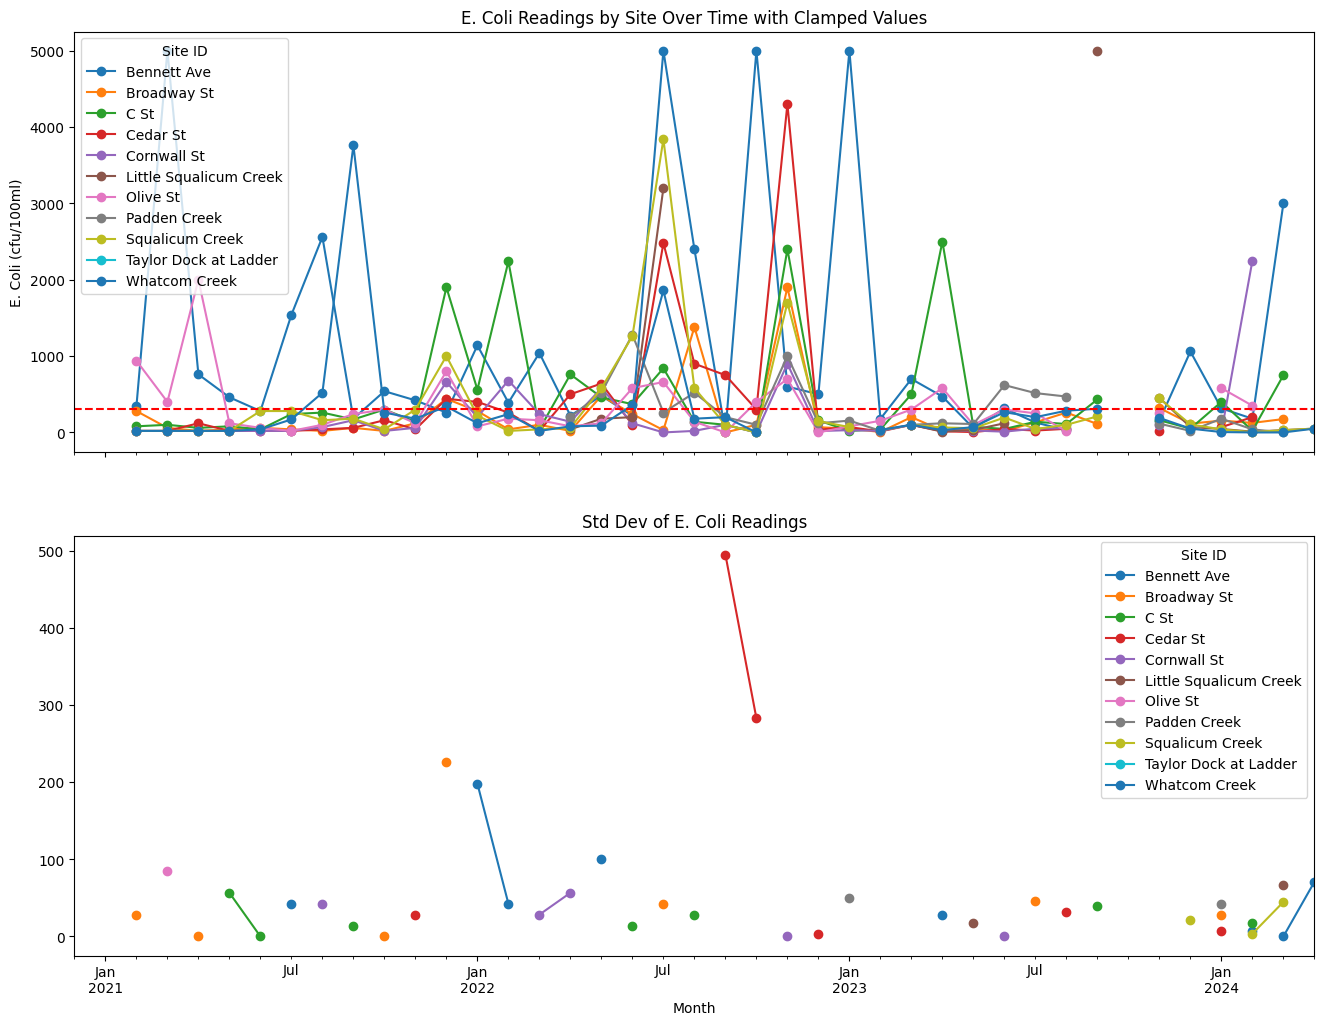

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
ecoli_aggregated_mean.clip(upper=5000).plot(ax=ax[0], marker='o', linestyle='-', title='E. Coli Readings by Site Over Time with Clamped Values')
ax[0].set_ylabel('E. Coli (cfu/100ml)')
ax[0].axhline(y=ecoli_threshold, color='red', linestyle='--', label='E. Coli Threshold (cfu/100ml)')
ecoli_aggregated_std.plot(ax=ax[1], marker='o', linestyle='-', title='Std Dev of E. Coli Readings')

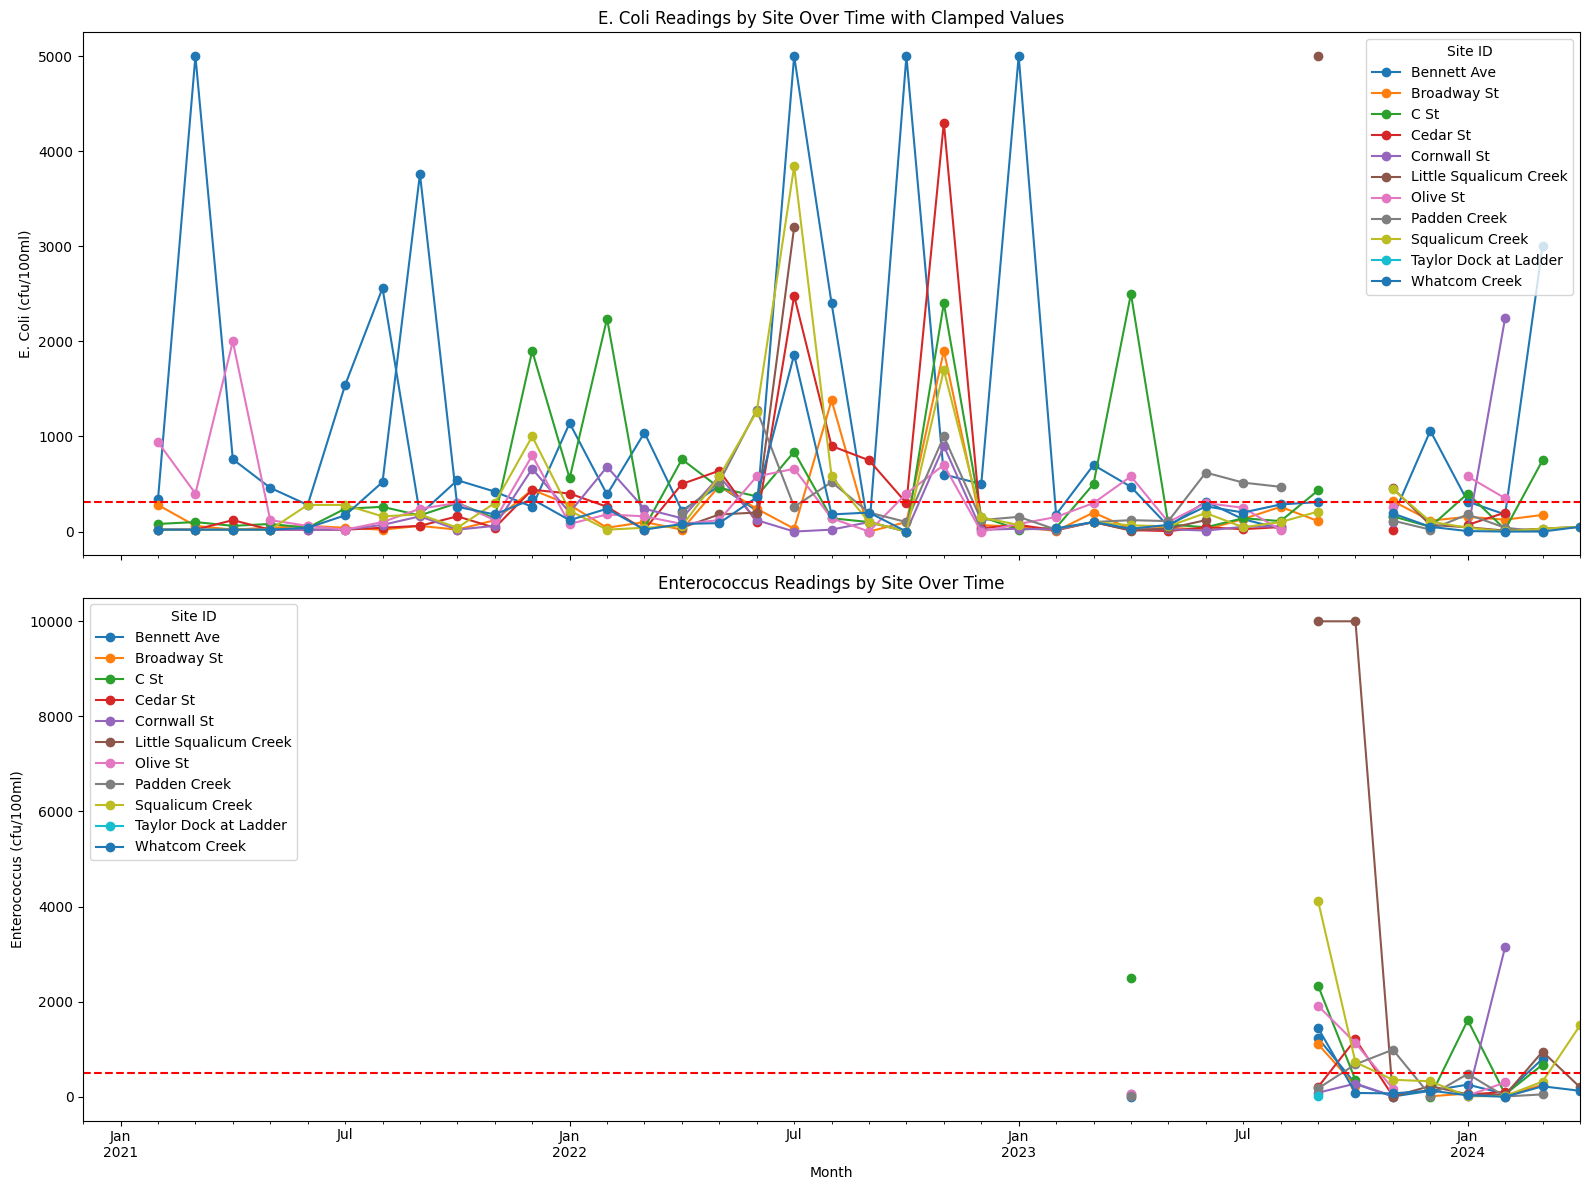

In [23]:
# Plotting the control charts
fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
ecoli_aggregated_mean.clip(upper=5000).plot(ax=ax[0], marker='o', linestyle='-', title='E. Coli Readings by Site Over Time with Clamped Values')
ax[0].set_ylabel('E. Coli (cfu/100ml)')
ax[0].axhline(y=ecoli_threshold, color='red', linestyle='--', label='E. Coli Threshold (cfu/100ml)')
enterococcus_aggregated.plot(ax=ax[1], marker='o', linestyle='-', title='Enterococcus Readings by Site Over Time')
ax[1].set_ylabel('Enterococcus (cfu/100ml)')
ax[1].axhline(y=enterococcus_threshold, color='red', linestyle='--', label='Enterococcus Threshold (cfu/100ml)')
plt.tight_layout()
plt.show()

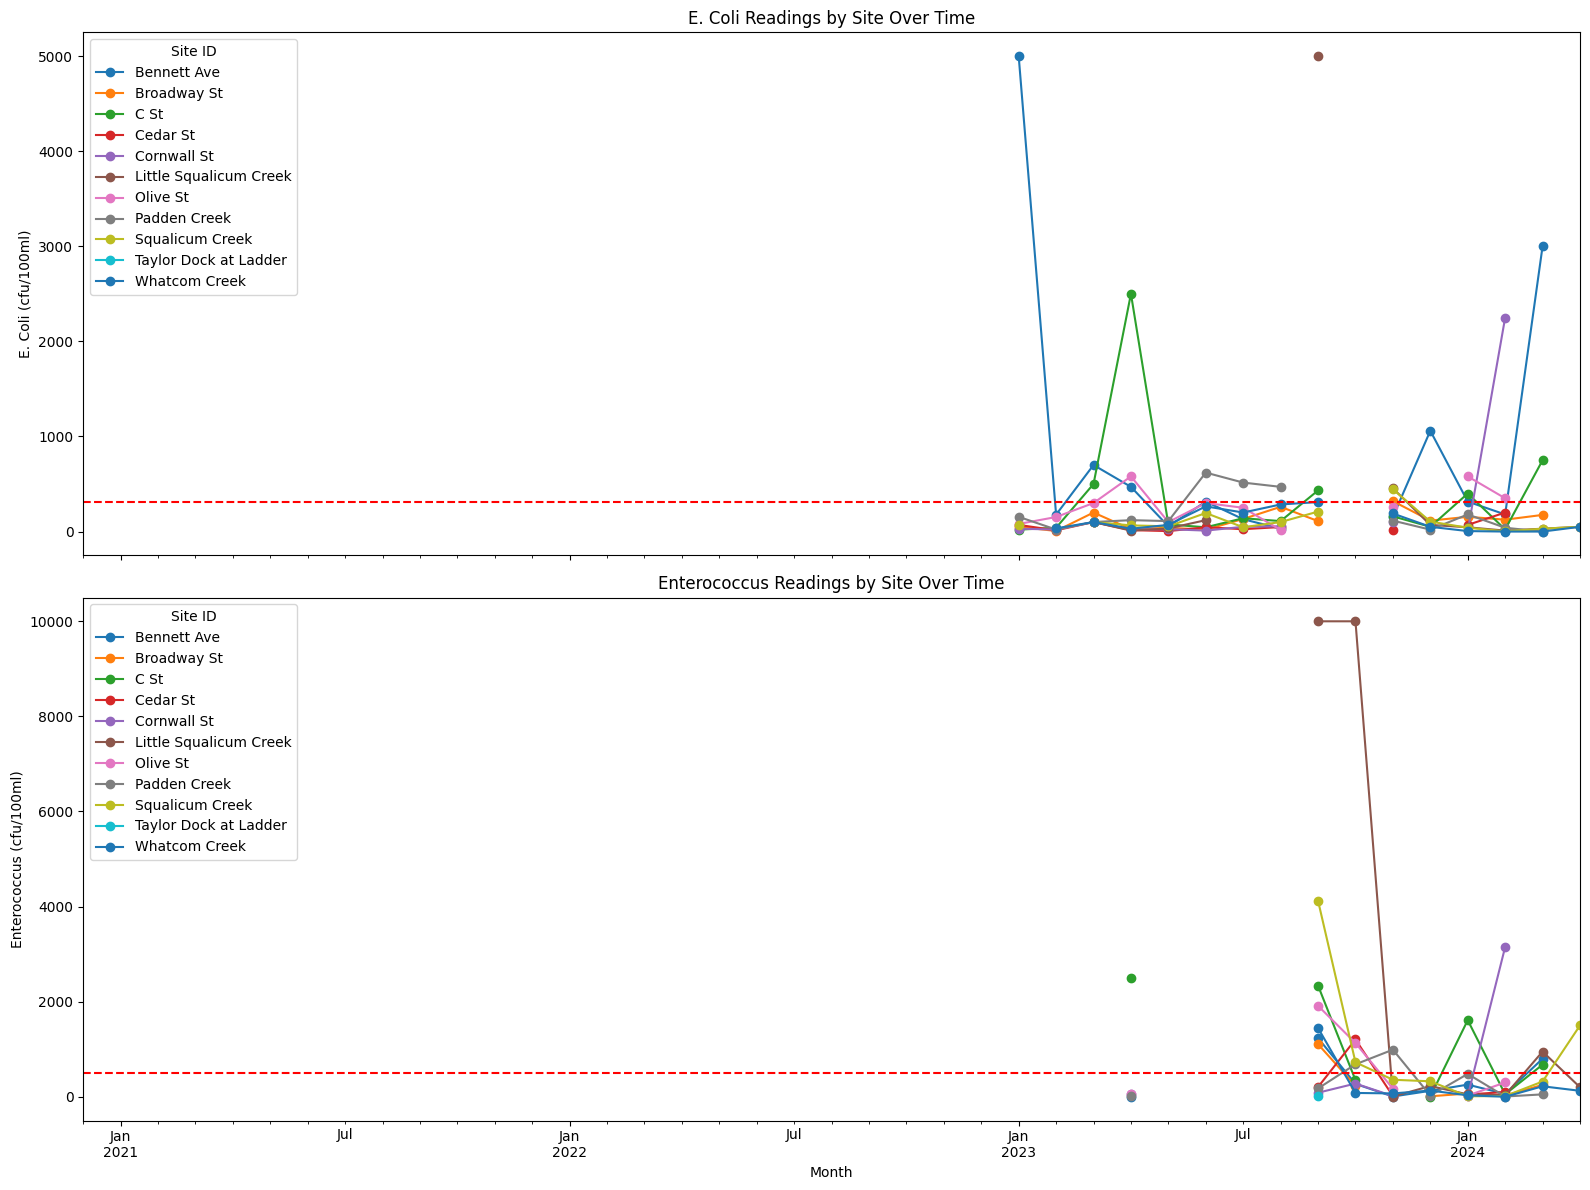

In [25]:
ecoli_aggregated_mean = ecoli_aggregated_mean[ecoli_aggregated_mean.index >= '2023-01']
enterococcus_aggregated_mean = enterococcus_aggregated[enterococcus_aggregated.index >= '2023-01']

fig, ax = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
ecoli_aggregated_mean.clip(upper=5000).plot(ax=ax[0], marker='o', linestyle='-', title='E. Coli Readings by Site Over Time')
ax[0].set_ylabel('E. Coli (cfu/100ml)')
ax[0].axhline(y=ecoli_threshold, color='red', linestyle='--', label='E. Coli Threshold (cfu/100ml)')
enterococcus_aggregated.plot(ax=ax[1], marker='o', linestyle='-', title='Enterococcus Readings by Site Over Time')
ax[1].set_ylabel('Enterococcus (cfu/100ml)')
ax[1].axhline(y=enterococcus_threshold, color='red', linestyle='--', label='Enterococcus Threshold (cfu/100ml)')

plt.tight_layout()
plt.show()

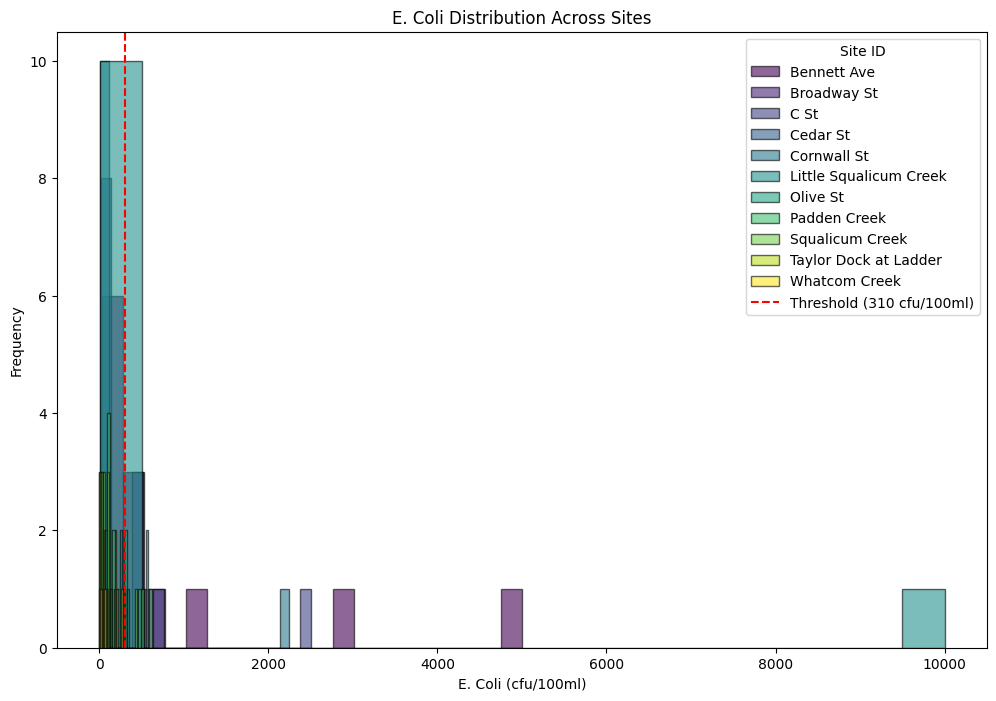

In [28]:
# Generate histograms
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(ecoli_aggregated_mean.columns)))

for (site, values), color in zip(ecoli_aggregated_mean.items(), colors):
    ax.hist(values.dropna(), bins=20, color=color, alpha=0.6, edgecolor='black', label=site)

ax.axvline(x=ecoli_threshold, color='red', linestyle='--', label='Threshold (310 cfu/100ml)')
ax.set_title('E. Coli Distribution Across Sites')
ax.set_xlabel('E. Coli (cfu/100ml)')
ax.set_ylabel('Frequency')
ax.legend(title='Site ID')
plt.show()

In [29]:
# Calculate exceedances for E. coli
ecoli_exceedances = ecoli[ecoli['E. Coli'] > ecoli_threshold]
ecoli_exceedances['Year'] = ecoli_exceedances['Sample Date'].dt.year
exceedance_counts = ecoli_exceedances.groupby(['Year', 'Site ID']).size().reset_index(name='Exceedance Count')
total_counts = ecoli.groupby([ecoli['Sample Date'].dt.year, 'Site ID']).size().reset_index(name='Total Readings')
total_counts.rename(columns={'Sample Date': 'Year'}, inplace=True)
exceedance_data = pd.merge(total_counts, exceedance_counts, on=['Year', 'Site ID'], how='left').fillna(0)
exceedance_data['Exceedance Percentage'] = (exceedance_data['Exceedance Count'] / exceedance_data['Total Readings']) * 100

print(exceedance_data)

      Year                 Site ID  Total Readings  Exceedance Count  \
0   2020.0                    C St               1               0.0   
1   2020.0                Cedar St               1               0.0   
2   2021.0             Bennett Ave              11               8.0   
3   2021.0             Broadway St              15               1.0   
4   2021.0                    C St              14               1.0   
5   2021.0                Cedar St              12               1.0   
6   2021.0             Cornwall St              12               1.0   
7   2021.0                Olive St              12               5.0   
8   2021.0         Squalicum Creek              11               1.0   
9   2021.0           Whatcom Creek              12               3.0   
10  2022.0             Bennett Ave              14              11.0   
11  2022.0             Broadway St              13               3.0   
12  2022.0                    C St              14              

C:\Users\gwlund.LEINET\AppData\Local\Temp\ipykernel_44524\108208123.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecoli_exceedances['Year'] = ecoli_exceedances['Sample Date'].dt.year
